In [2]:
# Importing standard Qiskit libraries
# from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# import qiskit.providers.aer 

# import QasmSimulator
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.quantum_info import Kraus

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

# Needed for functions
import numpy as np
from numpy import pi
import time
from copy import deepcopy
import pandas as pd

# to install packages to actual python
# !unset PYTHONNOUSERSITE

In [3]:
def OR(a,b,c,d,e,circuit):
    circuit.x(a)
    circuit.x(b)
    circuit.x(c)
    circuit.ccx(a,b,d)
    circuit.ccx(c,d,e)
    circuit.x(a)
    circuit.x(b)
    circuit.x(c)
    circuit.x(e)
    circuit.reset(d)

def AND(a,b,c,d,e,circuit):
    circuit.ccx(a,b,d)
    circuit.ccx(c,d,e)
    circuit.reset(d)
    
def had3(e,a,b,c,circuit,par):
    circuit.ch(e,abs(a)-1)
    circuit.ch(e,abs(b)-1)
    circuit.ch(e,abs(c)-1)
    
def hadAll(e,a,b,c,circuit,par):
    for b in range(par['nQ']):
        circuit.ch(e,b)
#     circuit.ch(e,abs(a)-1)
#     circuit.ch(e,abs(b)-1)
#     circuit.ch(e,abs(c)-1)
    
        
def remStates(a,b,c,d,circuit):
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
    
    circuit.rcccx(abs(a)-1,abs(b)-1,abs(c)-1,d)
        
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
         
def endRem(a,b,c,d,e,circuit):
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
        
def qft3(c,q1,q2,q3):
    c.h(abs(q3)-1)
    c.cp(pi/4, abs(q1)-1, abs(q3)-1)
    c.cp(pi/2, abs(q2)-1, abs(q3)-1)
    c.h(abs(q2)-1)
    c.cp(pi/2, abs(q1)-1, abs(q2)-1)
    c.h(abs(q1)-1)
    c.swap(abs(q1)-1,abs(q3)-1)
    
def qft3i(c,q1,q2,q3):
    c.swap(abs(q1)-1,abs(q3)-1)
    c.h(abs(q1)-1)
    c.cp(-pi/2, abs(q1)-1, abs(q2)-1)
    c.h(abs(q2)-1)
    c.cp(-pi/2, abs(q2)-1, abs(q3)-1)
    c.cp(-pi/4, abs(q1)-1, abs(q3)-1)
    c.h(abs(q3)-1)

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n, s):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[s:n+s])
    return circuit.decompose() # .decompose() allows us to see the individual gates
    

In [4]:
def buildSatSingleSolution(numVar):
    sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3]]
    for n in range(4,numVar+1):
        sat.append([2,3,n])
        sat.append([-2,-3,-n])
        sat.append([-2,-3,n])
        
    return sat

In [5]:
# SAT problem that will be implemented in circuit
# sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3],[-2,-3,4],[-2,-3,-4],[-2,-3,5],[-2,-3,-5],[-2,-3,6],[-2,-3,-6],[-2,-3,7],[-2,-3,-7],[2,3,4],[2,3,5],[2,3,6],[2,3,7]]

def buildCircuit(par,measure):
    helper = 1 #number of ancillary qubits
    h = par['nQ'] #qubit that can be used for calculations

    qr = QuantumRegister(par['nQ']+helper, 'q')
    cr = ClassicalRegister(par['nQ'], 'c')
    c = QuantumCircuit(qr, cr)

    # Hadimard all qubits used in SAT
    if par['had']:
        for x in range(par['nQ']):
            c.h(x)
                
    for n in range(par['numIt']): # Repeat circuit numIt times
        for clause in par['sat']: # loop through all clauses in the SAT instance
            
            
            remStates(clause[0],clause[1],clause[2],h,c)
            had3(h,clause[0],clause[1],clause[2],c,par)
            c.reset(h)
            
            c.barrier(qr)  
            
    if measure:
        c.measure(qr[:-1],cr)
            
    return c

In [6]:
def setup(nQ):
    par = {}
    par['nQ'] = nQ

    #Plotting Conditionals
    par['latex'] = True
    par['statevector'] = True
    par['measure'] = False
    par['saveEnd'] = False
    par['figName'] = "Plots/TestSave2/{:0>6}.png"
    par['sat'] = buildSatSingleSolution(par['nQ'])#[[1,2,3],[4,5,6]]
    par['numIt'] = len(par['sat'])
    par['had'] = True;
    print(par['numIt'])
    state = ''
    for q in range(nQ):
        state = state + '0'
    par['state'] = state
    
    return par

In [7]:
# n = 4
par = setup(3)
helper = 1 #number of ancillary qubits
h = par['nQ'] #qubit that can be used for calculations

qr = QuantumRegister(par['nQ']+helper, 'q')
cr = ClassicalRegister(par['nQ'], 'c')
c = QuantumCircuit(qr, cr)

for x in range(par['nQ']):
    c.h(x)
    
remStates(1,-2,-3,h,c)
had3(h,1,-2,-3,c,par)

k = Kraus(c)

print(k)

7
Kraus([[[ 3.53553391e-01+4.04984514e-18j,
          3.53553391e-01-9.31312648e-18j,
          3.53553391e-01-9.31312648e-18j,
          3.53553391e-01-9.31312648e-18j,
          3.53553391e-01-9.31312648e-18j,
          3.53553391e-01-9.31312648e-18j,
          3.53553391e-01-9.31312648e-18j,
          3.53553391e-01-9.31312648e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.0000

In [30]:
k = Kraus(c,input_dims=(2, 2, 2, 2), output_dims=(2, 2))
# print(k)
k.reshape(num_qubits=3)

# input_dims=[2, 2, 2, 2],output_dims=[4, 4]
# .to_operator()

QiskitError: 'Number of left qubits does not match matrix shape'

19
-23.34362554550171
this is it:  0.7554678103202576
24.25296950340271  : time taken


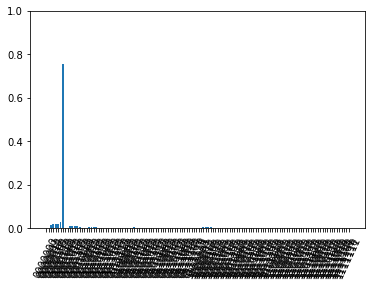

In [6]:
t = time.time()
n = 3
par = setup(n)

# par['sat'] = [[-1,2,-3],[1,-3,-4],[2,3,4]]#
par['numIt']  = 3*n -2

# Build circuit
start = time.time()
c = buildCircuit(par,False)

if(par['statevector']):
    # Execute and get counts
    DM = qi.DensityMatrix.from_instruction(c)
    # probs = DM.probabilities_dict()
    DM2 = qi.partial_trace(DM,[par['nQ']])
    probs = DM2.probabilities_dict()
    
print(start-time.time())
    
names = list(probs.keys())
values = list(probs.values())
print("this is it: ", list(probs.values())[7])
# plt.bar(probs)

plt.bar(range(len(probs)), values, tick_label=names)
plt.xticks(rotation = 65)

# print(values)
# print(c)
ax = plt.gca()
ax.set_ylim([0, 1])
# name = "Plots/HardSAT20/{:0>3}.png".format(x)

name = "plots2/testPlot.png"
plt.savefig(name)

# dm.draw('latex', prefix='\\rho_{AB} = ')

# b = circuit_drawer(c,output='mpl')
# name = "plots2/testPlot2.png"
# b.savefig(name)

print(time.time() - t, " : time taken")


In [7]:
from qiskit import Aer, transpile
# import qiskit.providers.aer
from qiskit_aer import AerError

print(Aer.backends())

# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
try:
    simulator_gpu = Aer.get_backend('aer_simulator_density_matrix')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)



[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_statevector_gpu'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_density_matrix_gpu'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_unitary_gpu'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator'), PulseSimulator('pulse_simulator')]


In [9]:
n = 7
par = setup(n)
par['numIt']  = 3*n -2

# Build circuit
c = buildCircuit(par,True)

circ = transpile(c, simulator_gpu, optimization_level=0)

# Run and get counts
shots = 10000

name = ""
for z in range(n-3):
    name+="0"
name+="111"

# Here we will test all the different simulation methods aer, statevector, density_matrix and unitary

# aer_simulator simulation method
# try:
#     simulator_aer = Aer.get_backend('aer_simulator')
#     simulator_aer.set_options(device='CPU')
# except AerError as e:
#     print(e)
# t = time.time() 
# circ = transpile(c, simulator_aer, optimization_level=0)
# print(time.time() - t, " : time taken for compile")
# t = time.time()
# job_aer = simulator_aer.run(circ, shots=shots)
# counts_aer = job_aer.result().get_counts(0)
# print(time.time() - t, " : time taken for aer")
# print(counts_aer[name]/shots)

# Statevector simulation method
# try:
#     simulator_statevector = Aer.get_backend('aer_simulator_statevector')
#     simulator_statevector.set_options(device='CPU')
# except AerError as e:
#     print(e)
# t = time.time() 
# circ = transpile(c, simulator_statevector, optimization_level=0)
# print(time.time() - t, " : time taken for compile")
# t = time.time()
# job_statevector = simulator_statevector.run(circ, shots=shots)
# counts_statevector = job_statevector.result().get_counts(0)
# print(time.time() - t, " : time taken for statevector")
# print(counts_statevector[name]/shots)

# # Density Matrix simulation method
try:
    simulator_density_matrix = Aer.get_backend('aer_simulator_density_matrix')
    simulator_density_matrix.set_options(device='GPU')
except AerError as e:
    print(e)
t = time.time()    
job_density_matrix = simulator_density_matrix.run(circ, shots=shots)
counts_density_matrix = job_density_matrix.result().get_counts(0)
print(time.time() - t, " : time taken for density_matrix")
print(counts_density_matrix[name]/shots)

# Density Matrix simulation method cpu
try:
    simulator_density_matrix = Aer.get_backend('aer_simulator_density_matrix')
    simulator_density_matrix.set_options(device='CPU')
except AerError as e:
    print(e)
t = time.time() 
circ = transpile(c, simulator_density_matrix, optimization_level=0)
print(time.time() - t, " : time taken for compile")
t = time.time()    
job_density_matrix = simulator_density_matrix.run(circ, shots=shots)
counts_density_matrix = job_density_matrix.result().get_counts(0)
print(time.time() - t, " : time taken for density_matrix cpu")
print(counts_density_matrix[name]/shots)

# Unitary Product State simulation method - doesn't work
# try:
#     simulator_unitary = Aer.get_backend('aer_simulator_unitary')
#     simulator_unitary.set_options(device='CPU')
# except AerError as e:
#     print(e)
# t = time.time() 
# circ = transpile(c, simulator_unitary, optimization_level=0)
# print(time.time() - t, " : time taken for compile")
# t = time.time()
# job_unitary = simulator_unitary.run(circ, shots=shots)
# counts_unitary = job_unitary.result().get_counts(0)
# print(time.time() - t, " : time taken for unitary")
# print(counts_unitary[name]/shots)

# matrix_product_state

# try:
#     simulator_matrix_product_state = Aer.get_backend('aer_simulator_matrix_product_state')
#     simulator_matrix_product_state.set_options(device='CPU')
# except AerError as e:
#     print(e)
# t = time.time() 
# circ = transpile(c, simulator_matrix_product_state, optimization_level=0)
# print(time.time() - t, " : time taken for compile")
# t = time.time()
# job_matrix_product_state = simulator_matrix_product_state.run(circ, shots=shots)
# counts_matrix_product_state = job_matrix_product_state.result().get_counts(0)
# print(time.time() - t, " : time taken for matrix_product_state")
# print(counts_unitary[name]/shots)

# plot_histogram(statevector,
#                title='Counts for different simulation methods',
#                legend=['statevector'])

# plot_histogram(counts, title=simulator)
# plot_histogram(probs, title=simulator)

#gpu might not be working because I cannot properly uninstall qiskit-aer and only install qiskit-aer-gpu since the package is in use by the long run


19
0.7366294860839844  : time taken for density_matrix
0.7489
0.924574613571167  : time taken for compile
6.458087682723999  : time taken for density_matrix cpu
0.7579


7
time to finish  3  qubit problem with  7  clauses:  -0.061170101165771484
this is it:  0.8187428845172958
[3]
10
time to finish  4  qubit problem with  10  clauses:  -0.1752300262451172
this is it:  0.7659239179346701
[3, 4]
13
time to finish  5  qubit problem with  13  clauses:  -0.6949489116668701
this is it:  0.7510740258477393
[3, 4, 5]
16
time to finish  6  qubit problem with  16  clauses:  -3.5586657524108887
this is it:  0.7506123762203448
[3, 4, 5, 6]
19
time to finish  7  qubit problem with  19  clauses:  -19.12430500984192
this is it:  0.7554678103202576
[3, 4, 5, 6, 7]
22
time to finish  8  qubit problem with  22  clauses:  -105.1512393951416
this is it:  0.7623790571580137
[3, 4, 5, 6, 7, 8]
25
time to finish  9  qubit problem with  25  clauses:  -571.0361802577972
this is it:  0.7700604112657375
[3, 4, 5, 6, 7, 8, 9]
28


KeyboardInterrupt: 

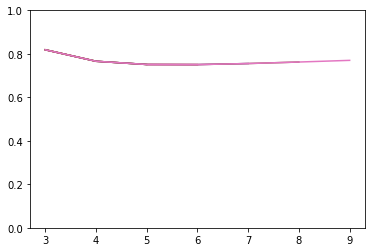

In [7]:
lim = 25
sol = []
labels = []

for n in range(3,lim):
    par = setup(n)

    # par['sat'] = [[-1,2,-3],[1,-3,-4],[2,3,4]]#
#     par['numIt']  = 7 + 3*(n-3)

    # Build circuit
    start = time.time()
    c = buildCircuit(par)

    if(par['statevector']):
        # Execute and get counts
        DM = qi.DensityMatrix.from_instruction(c)
        # probs = DM.probabilities_dict()
        DM2 = qi.partial_trace(DM,[par['nQ']])
        probs = DM2.probabilities_dict()

    print("time to finish ", n , " qubit problem with ", par["numIt"], " clauses: " , start-time.time())
    
    names = list(probs.keys())
    values = list(probs.values())
    print("this is it: ", list(probs.values())[7])
    sol.append(list(probs.values())[7])
    labels.append(n)
    print(labels)
    plt.plot(np.array(labels),np.array(sol))

    ax = plt.gca()
    ax.set_ylim([0, 1])
    name = "plots2/onTheFly/{:0>3}.png".format(n)

#     name = "plots2/BigDebug.png"
    plt.savefig(name)

    
# b = circuit_drawer(c,output='mpl')
#     name = "plots2/CircCheck.png"
#     b.savefig(name)


# dm.draw('latex', prefix='\\rho_{AB} = ')




In [10]:
print(qiskit_aer.backends.aerbackend.AerBackend.available_devices())

NameError: name 'qiskit_aer' is not defined

In [5]:
# SAT problem that will be implemented in circuit
# sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3],[-2,-3,4],[-2,-3,-4],[-2,-3,5],[-2,-3,-5],[-2,-3,6],[-2,-3,-6],[-2,-3,7],[-2,-3,-7],[2,3,4],[2,3,5],[2,3,6],[2,3,7]]

def runAlgTest(par):
    if(par['statevector']):
        backend = Aer.get_backend('statevector_simulator')
    else:       
        backend = Aer.get_backend('simulator_mps')#qasm_simulator

    helper = 1 #number of ancillary qubits
    h = par['nQ']   #qubit that can be used for calculations 
    
    qr = QuantumRegister(par['nQ']+helper, 'q')
    cr = ClassicalRegister(par['nQ'], 'c')
    c = QuantumCircuit(qr, cr)

    # Hadimard all qubits used in SAT
    for x in range(par['nQ']):
        c.h(x)
        
    probs = []
    p = 0     
    probs.append(p)
    while p < 0.75: # Repeat circuit until probability of measuring solution greater than 0.75
        for clause in par['sat']: # loop through all clauses in the SAT instance
            
            remStates(clause[0],clause[1],clause[2],h,c)
            had3(h,clause[0],clause[1],clause[2],c,par)
            c.reset(h)
    
        DM = qi.DensityMatrix.from_instruction(c)
        rho_S = qi.partial_trace(DM,[h]).probabilities_dict()
        p = list(rho_S.values())[0]
        probs.append(p)
    
    return probs

In [ ]:

    
start = time.time()
for x in range(9,10):
    par = setup(x)
    probs = runAlgTest(par)
    plt.plot(probs)
    plt.title("3SAT single solution")
    plt.xlabel("number of iterations of circuit")
    plt.ylabel("probability of measuring solution state")
    name = "Plots/ALGtest/workin3to14.png"
    plt.savefig(name)
print(start-time.time())

# plt.bar(probs)

